Unexpected marker at line 874: 10000
Error parsing run details at line 871 could not convert string to float: 'train() COMPLETED'


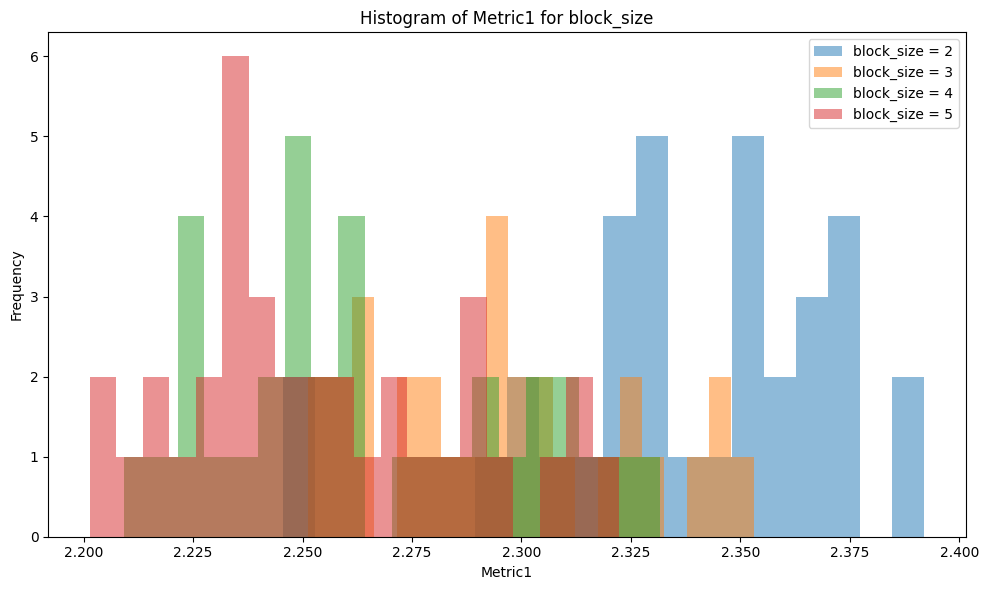

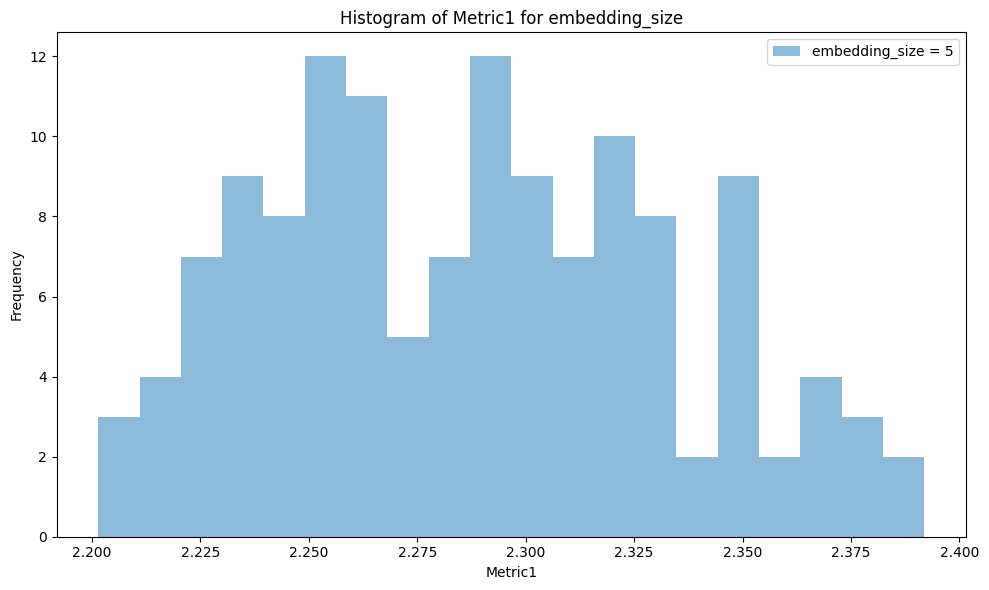

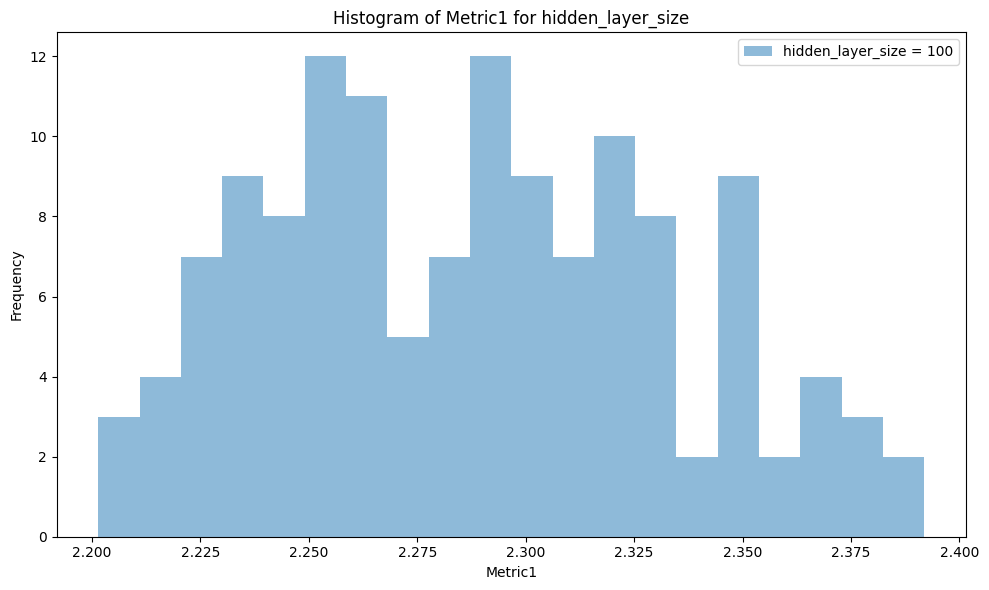

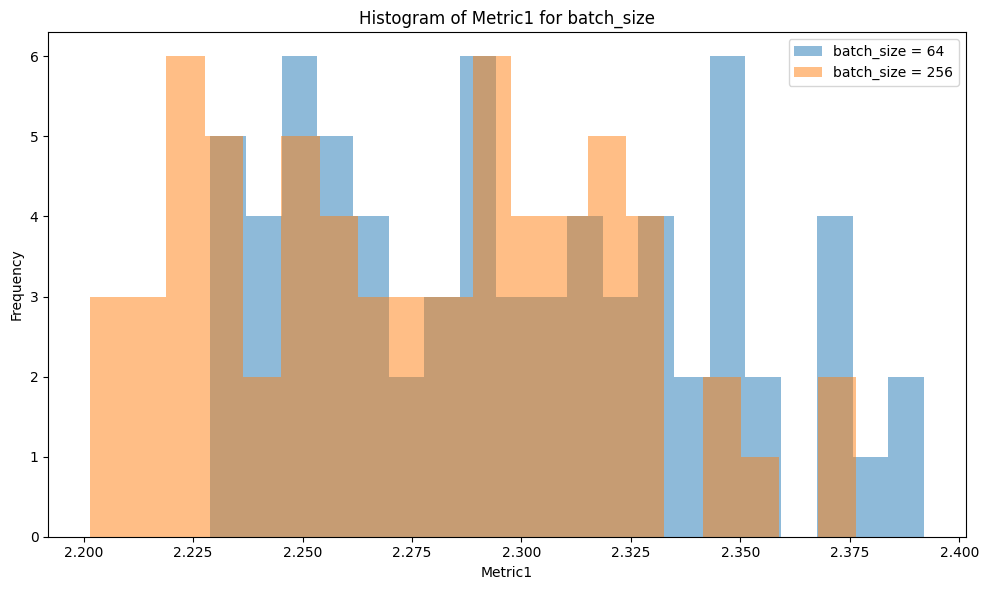

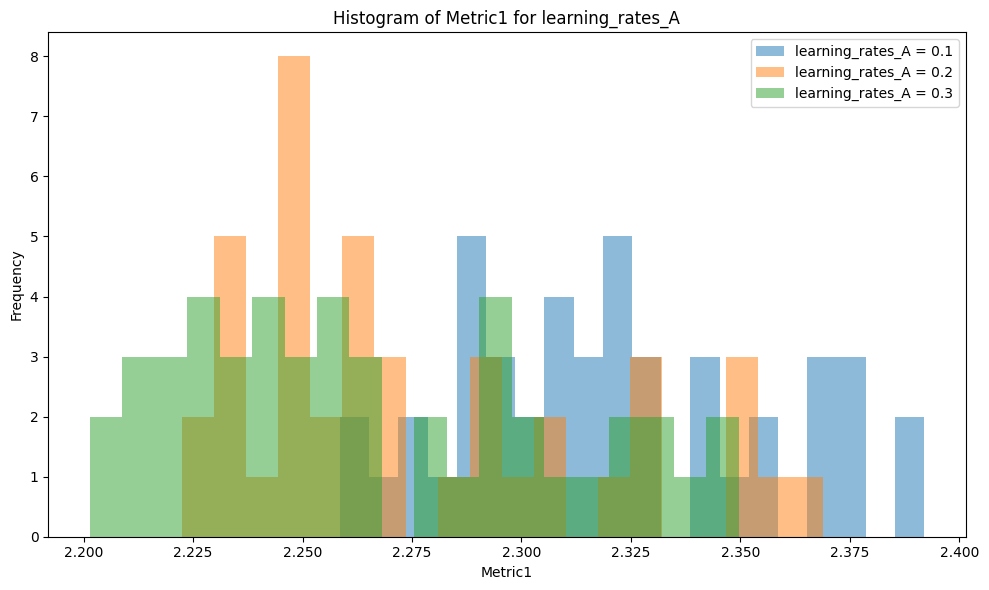

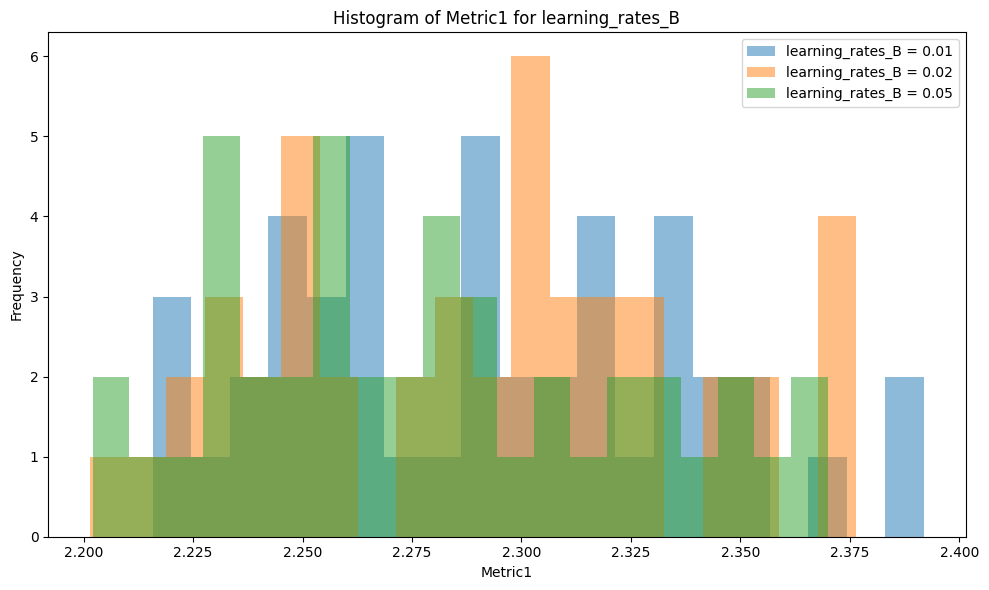

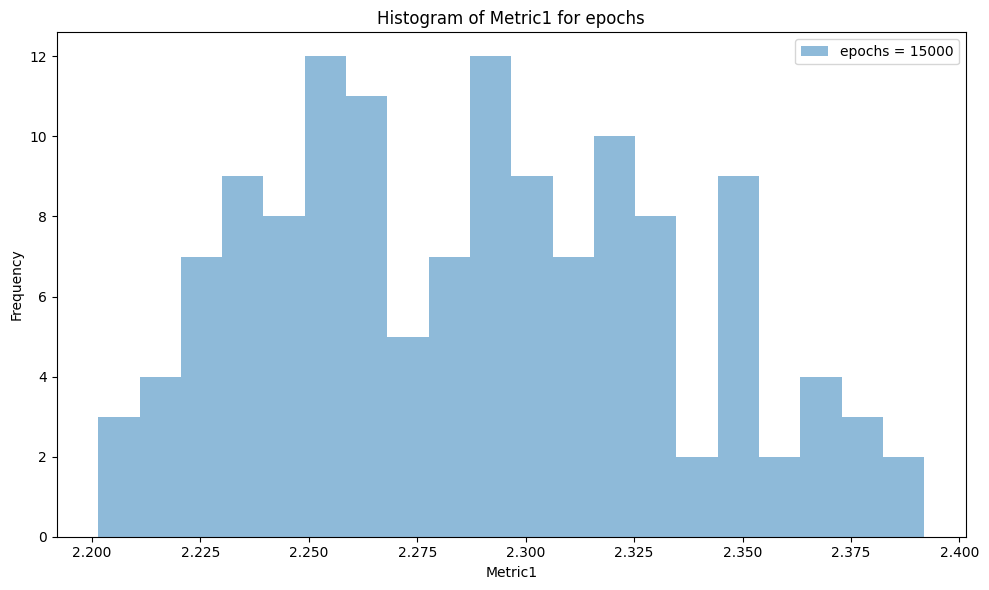

In [24]:
import re
from collections import defaultdict
import matplotlib.pyplot as plt
from pprint import pprint

def parse_key(key):
    """
    Parse a configuration key string into a dictionary of hyperparameter names and values.
    
    For example, a key like:
      "block_size_2__embedding_size_5__hidden_layer_size_100__batch_size_64__learning_rates_A_0.1__learning_rates_B_0.01__epochs_15000____hyperparam_search"
    
    will be parsed into:
      {
          "block_size": 2,
          "embedding_size": 5,
          "hidden_layer_size": 100,
          "batch_size": 64,
          "learning_rates_A": 0.1,
          "learning_rates_B": 0.01,
          "epochs": 15000,
      }
    """
    parts = key.split('__')
    result = {}
    for part in parts:
        if not part or "hyperparam_search" in part:
            continue
        # Split by the last underscore (in case a parameter name contains underscores)
        tokens = part.rsplit('_', 1)
        if len(tokens) != 2:
            continue
        param, val = tokens
        try:
            if '.' in val:
                val = float(val)
            else:
                val = int(val)
        except ValueError:
            pass
        result[param] = val
    return result

def parse_logs(filename):
    """
    Parse hyperparameter search logs into a dictionary mapping configuration keys to a list of run details.
    
    The log file is assumed to have entries like:
    
      HYPERPARAMETERS SEARCH, START <config key>
      starting run: <full config key with run_idx>
      <start_value>
      <end_value>
      train() COMPLETED
      <metric1>
      <metric2>
      
    Each run is parsed into a dictionary with keys 'run_idx', 'start', 'end', 'metric1', 'metric2', and the full config.
    """
    configs = {}
    current_config = None

    with open(filename, "r") as f:
        lines = [line.strip() for line in f if line.strip()]

    i = 0
    while i < len(lines):
        line = lines[i]
        
        # Identify a configuration header.
        if line.startswith("HYPERPARAMETERS SEARCH, START"):
            current_config = line.split("HYPERPARAMETERS SEARCH, START", 1)[1].strip()
            if current_config not in configs:
                configs[current_config] = []
            i += 1
            continue
        
        # Identify a run start.
        if line.startswith("starting run:"):
            run_line = line.split("starting run:", 1)[1].strip()
            run_idx_match = re.search(r"__run_idx_(\d+)", run_line)
            run_idx = int(run_idx_match.group(1)) if run_idx_match else None
            
            try:
                start_value = float(lines[i+1])
                end_value   = float(lines[i+2])
                if lines[i+3] != "train() COMPLETED":
                    print(f"Unexpected marker at line {i+3}: {lines[i+3]}")
                metric1 = float(lines[i+4])
                metric2 = float(lines[i+5])
            except (IndexError, ValueError) as e:
                print("Error parsing run details at line", i, e)
                break

            run_info = {
                "run_idx": run_idx,
                "start": start_value,
                "end": end_value,
                "metric1": metric1,
                "metric2": metric2,
                "full_run_config": run_line,
            }
            
            if current_config is not None:
                configs[current_config].append(run_info)
            else:
                print("Warning: Found a run without a preceding configuration header.")
            
            i += 6  # Skip the lines that belong to this run.
            continue
        
        i += 1
    return configs

def create_histograms(configs):
    """
    For each hyperparameter dimension, create a mapping from each parameter value to a list of metric1 values.
    
    Returns a dictionary of the form:
    {
        "block_size": {2: [metric1, metric1, ...], 4: [metric1, ...], ...},
        "embedding_size": {5: [...], 20: [...], ...},
        ...
    }
    """
    histograms = defaultdict(lambda: defaultdict(list))
    for config_str, runs in configs.items():
        params = parse_key(config_str)
        for run in runs:
            m1 = run.get("metric1")
            # For each hyperparameter in this configuration, add the run's metric1.
            for param, value in params.items():
                histograms[param][value].append(m1)
    return histograms

def plot_histograms(histograms):
    """
    For each hyperparameter dimension, plot a histogram using matplotlib.
    Each histogram will plot the distribution of metric1 values for each hyperparameter value.
    """
    for param, value_dict in histograms.items():
        plt.figure(figsize=(10, 6))
        plt.title(f"Histogram of Metric1 for {param}")
        # Plot a histogram for each hyperparameter value.
        for value, metrics in sorted(value_dict.items()):
            # Use 20 bins and some transparency (alpha) for overlapping histograms.
            plt.hist(metrics, bins=20, alpha=0.5, label=f"{param} = {value}")
        plt.xlabel("Metric1")
        plt.ylabel("Frequency")
        plt.legend()
        plt.tight_layout()
        plt.show()


# Change this to the path of your log file.
filename = "logs.txt"

# Parse the logs.
configs = parse_logs(filename)


# Create histograms data.
histograms = create_histograms(configs)

# Plot histograms using matplotlib.
plot_histograms(histograms)


Could not find 'train() COMPLETED' marker after run details starting at line 4199


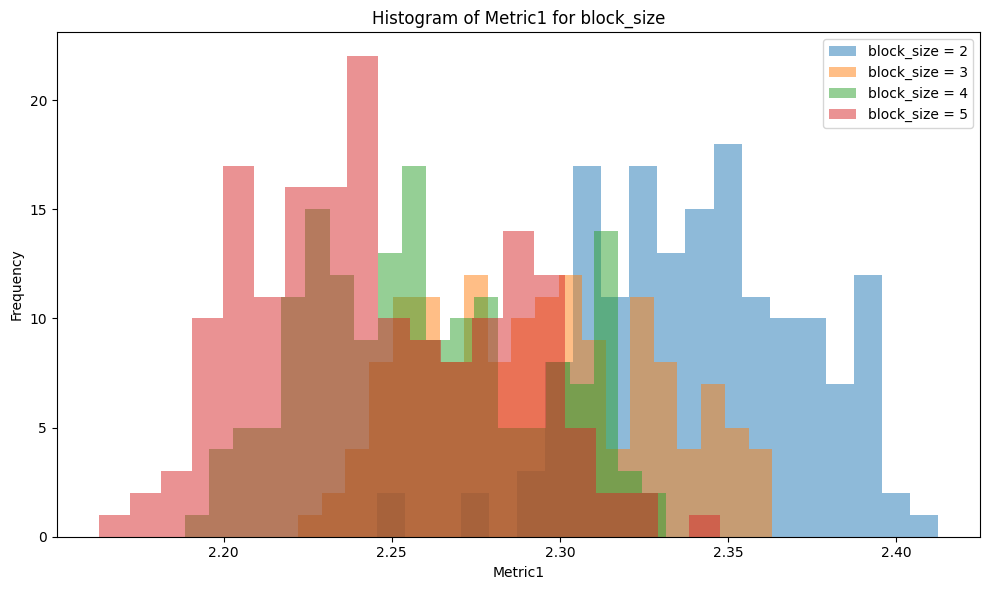

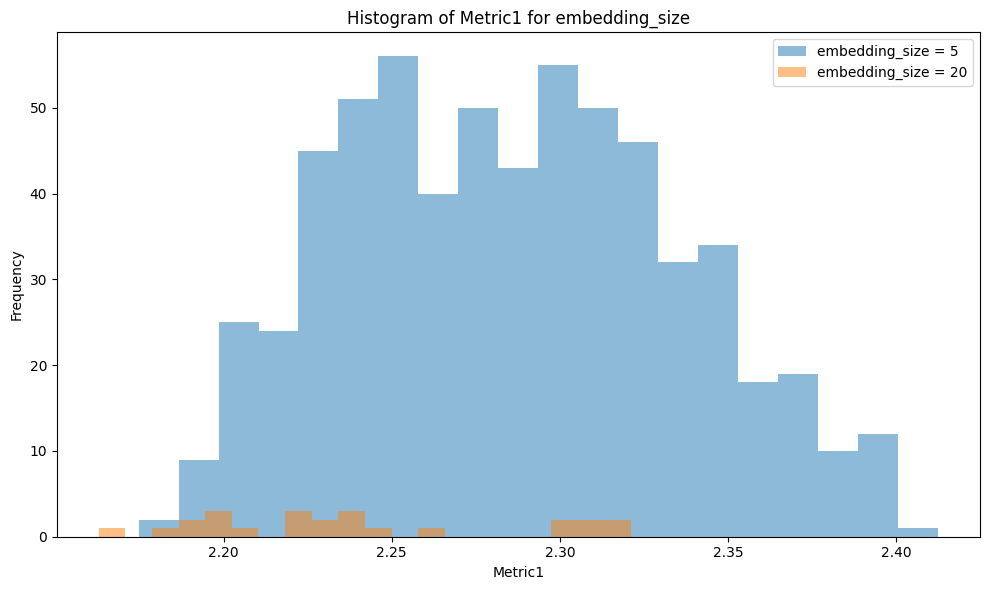

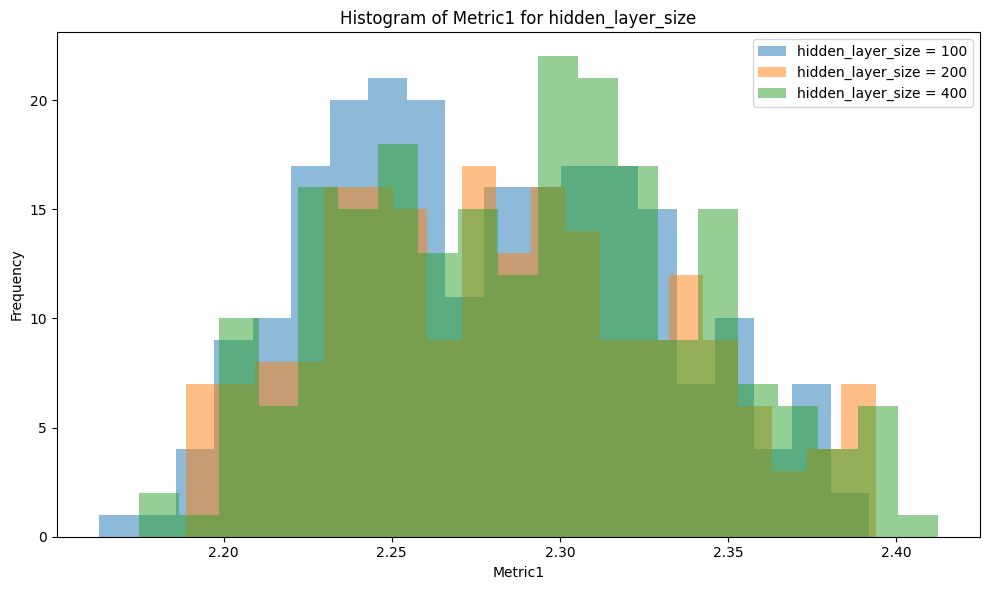

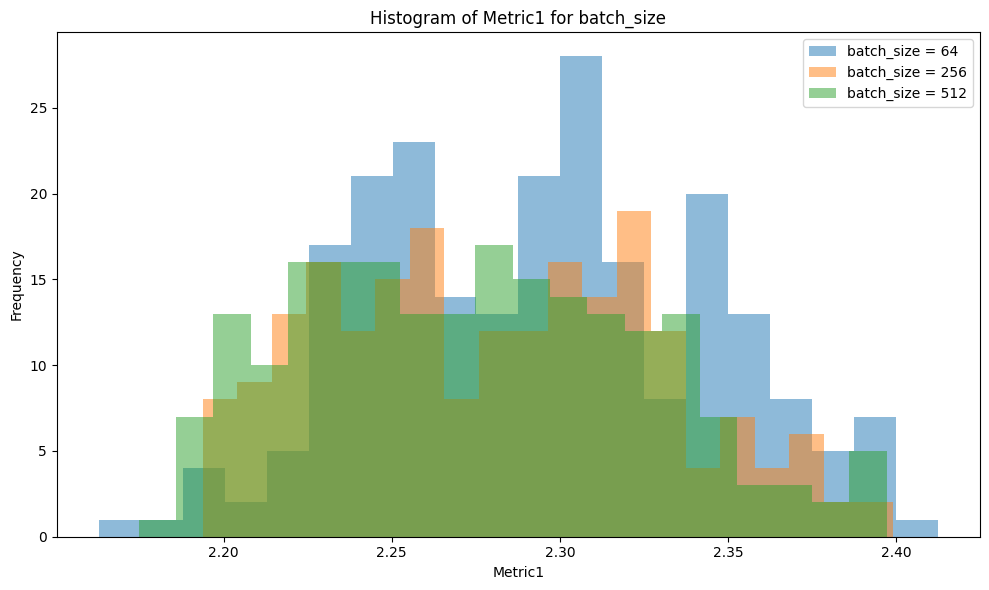

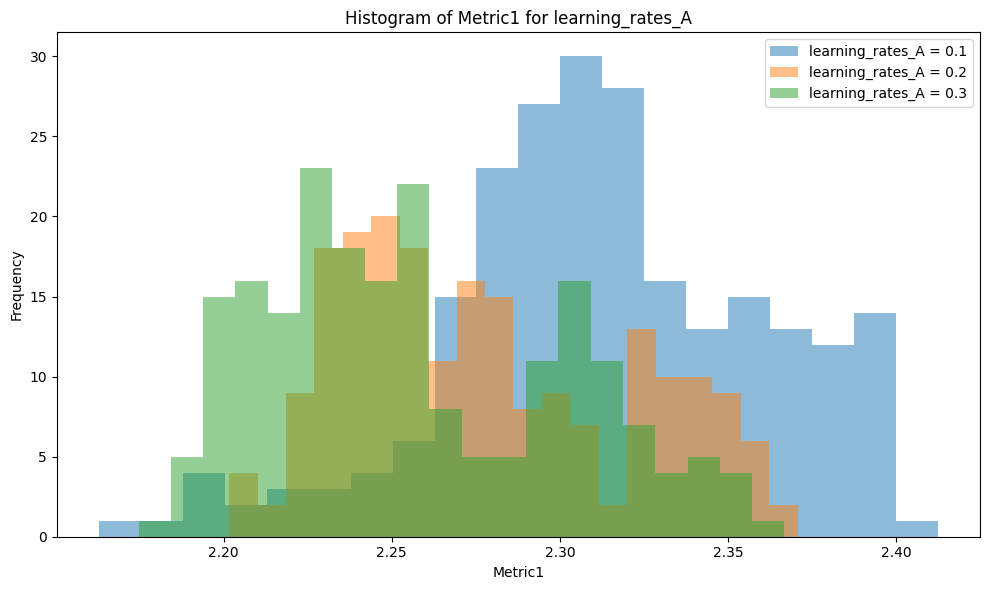

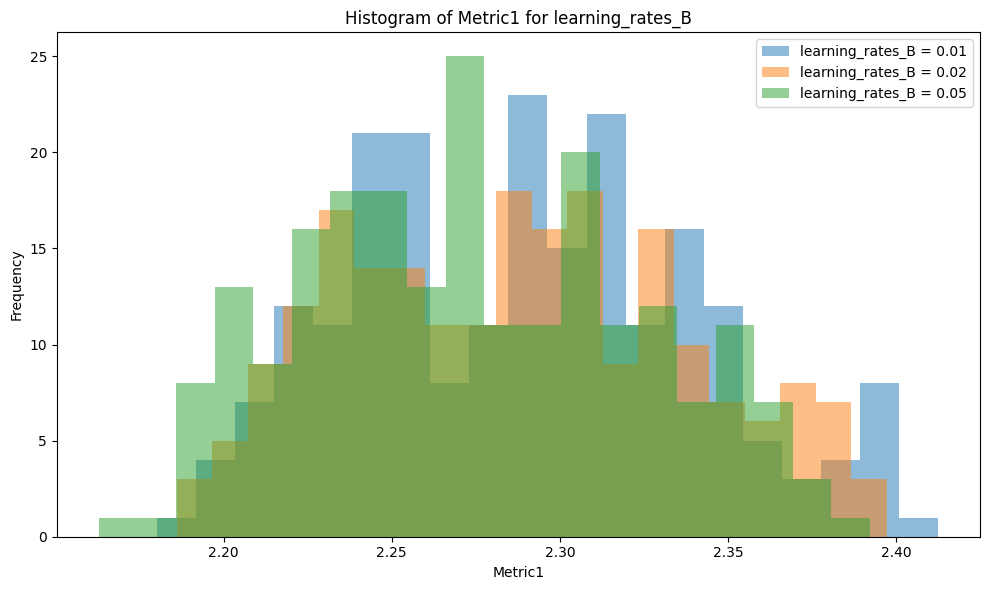

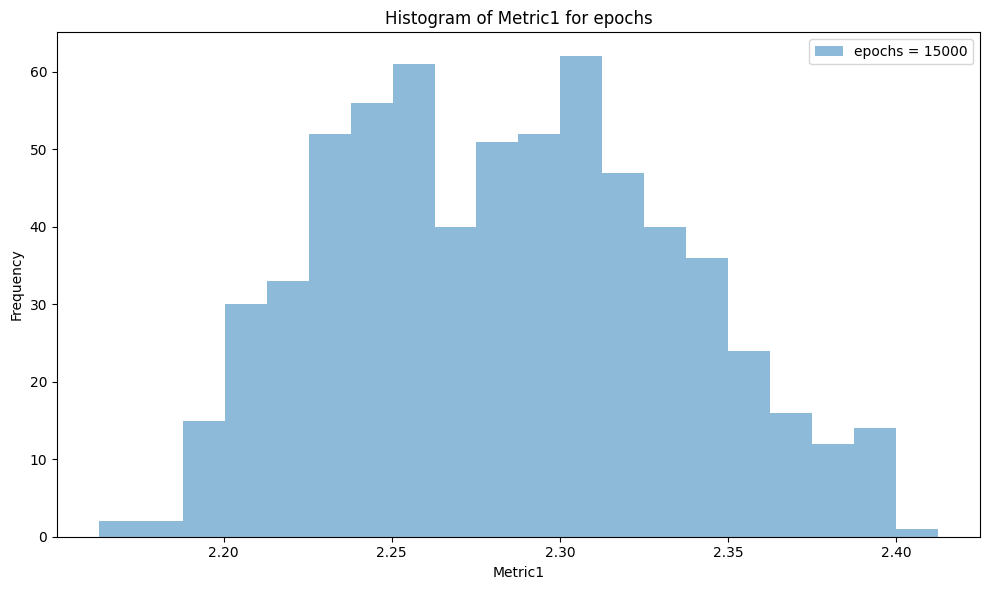

In [29]:
import re
from collections import defaultdict
import matplotlib.pyplot as plt
from pprint import pprint

def parse_key(key):
    """
    Parse a configuration key string into a dictionary of hyperparameter names and values.
    
    For example, a key like:
      "block_size_2__embedding_size_5__hidden_layer_size_100__batch_size_64__learning_rates_A_0.1__learning_rates_B_0.01__epochs_15000____hyperparam_search"
    
    will be parsed into:
      {
          "block_size": 2,
          "embedding_size": 5,
          "hidden_layer_size": 100,
          "batch_size": 64,
          "learning_rates_A": 0.1,
          "learning_rates_B": 0.01,
          "epochs": 15000,
      }
    """
    parts = key.split('__')
    result = {}
    for part in parts:
        # Skip empty parts or parts that (after stripping underscores) equal "hyperparam_search"
        if not part or part.strip('_') == "hyperparam_search":
            continue
        # Split by the last underscore to separate parameter name and value.
        tokens = part.rsplit('_', 1)
        if len(tokens) != 2:
            continue
        param, val = tokens
        try:
            # Convert to float if a dot is present; otherwise, int.
            if '.' in val:
                val = float(val)
            else:
                val = int(val)
        except ValueError:
            pass
        result[param] = val
    return result

def parse_logs(filename):
    """
    Parse hyperparameter search logs into a dictionary mapping configuration keys
    to a list of run details.
    
    Expected log entries:
    
      HYPERPARAMETERS SEARCH, START <config key>
      starting run: <full config key with run_idx>
      <numeric line 1>
      <numeric line 2>    <-- may be missing sometimes
      ... (possibly extra numeric lines)
      train() COMPLETED
      <metric1>
      <metric2>
      
    This function collects all numeric lines until the "train() COMPLETED" marker.
    If only one numeric value is found, it is used for both start and end.
    """
    configs = {}
    current_config = None

    # Regex to extract the header robustly.
    header_pattern = re.compile(r"HYPERPARAMETERS SEARCH, START\s+(.*?)(?:_+hyperparam_search)?\s*$")
    
    with open(filename, "r") as f:
        lines = [line.strip() for line in f if line.strip()]
    
    i = 0
    while i < len(lines):
        line = lines[i]
        
        # Check for a header line.
        header_match = header_pattern.match(line)
        if header_match:
            current_config = header_match.group(1)
            if current_config not in configs:
                configs[current_config] = []
            i += 1
            continue
        
        # Check for a run start.
        if line.startswith("starting run:"):
            run_line = line.split("starting run:", 1)[1].strip()
            run_idx_match = re.search(r"__run_idx_(\d+)", run_line)
            run_idx = int(run_idx_match.group(1)) if run_idx_match else None
            
            # Collect numeric lines until we hit the "train() COMPLETED" marker.
            j = i + 1
            numeric_lines = []
            while j < len(lines) and lines[j] != "train() COMPLETED":
                try:
                    num = float(lines[j])
                    numeric_lines.append(num)
                except ValueError:
                    # If conversion fails, break out.
                    break
                j += 1
            
            if j >= len(lines) or lines[j] != "train() COMPLETED":
                print(f"Could not find 'train() COMPLETED' marker after run details starting at line {i}")
                break
            
            # If we have no numeric lines, we cannot parse start/end.
            if len(numeric_lines) == 0:
                print(f"Not enough numeric values before marker at line {i}")
                i = j + 1
                continue
            
            # Use the first numeric value as start.
            # If there is a second, use that as end; otherwise, duplicate the first.
            if len(numeric_lines) >= 2:
                start_value = numeric_lines[0]
                end_value = numeric_lines[1]
            else:
                start_value = numeric_lines[0]
                end_value = numeric_lines[0]
            
            # After the marker, expect two metric lines.
            try:
                metric1 = float(lines[j+1])
                metric2 = float(lines[j+2])
            except (IndexError, ValueError) as e:
                print(f"Error parsing metrics after marker at line {j}: {e}")
                break
            
            run_info = {
                "run_idx": run_idx,
                "start": start_value,
                "end": end_value,
                "metric1": metric1,
                "metric2": metric2,
                "full_run_config": run_line,
            }
            
            if current_config is not None:
                configs[current_config].append(run_info)
            else:
                print("Warning: Found a run without a preceding configuration header.")
            
            # Advance i past the run block.
            i = j + 3
            continue
        
        i += 1
    return configs

def create_histograms(configs):
    """
    For each hyperparameter dimension, create a mapping from each parameter value to a list of metric1 values.
    
    Returns a dictionary of the form:
      {
          "block_size": {2: [metric1, metric1, ...], 4: [metric1, ...], ...},
          "embedding_size": {5: [...], 20: [...], ...},
          ...
      }
    """
    histograms = defaultdict(lambda: defaultdict(list))
    for config_str, runs in configs.items():
        params = parse_key(config_str)
        for run in runs:
            m1 = run.get("metric1")
            for param, value in params.items():
                histograms[param][value].append(m1)
    return histograms

def plot_histograms(histograms):
    """
    Plot a histogram using matplotlib for each hyperparameter dimension.
    """
    for param, value_dict in histograms.items():
        plt.figure(figsize=(10, 6))
        plt.title(f"Histogram of Metric1 for {param}")
        for value, metrics in sorted(value_dict.items()):
            plt.hist(metrics, bins=20, alpha=0.5, label=f"{param} = {value}")
        plt.xlabel("Metric1")
        plt.ylabel("Frequency")
        plt.legend()
        plt.tight_layout()
        plt.show()


filename = "logs.txt"  # Update this to your actual log file path

configs = parse_logs(filename)


histograms = create_histograms(configs)
plot_histograms(histograms)


In [47]:
values = []
for k,v in configs.items():
    try:
        values.append([(v[0]['metric1'] + v[1]['metric1']) / 2, (v[0]['metric2'] + v[1]['metric2']) / 2, k])
    except IndexError:
        pass

In [39]:
(v[0]['metric1'] + v[1]['metric1']) / 2, (v[0]['metric2'] + v[1]['metric2']) / 2, k

(2.3913867473602295,
 2.3878241777420044,
 'block_size_2__embedding_size_5__hidden_layer_size_100__batch_size_64__learning_rates_A_0.1__learning_rates_B_0.01__epochs_15000')

In [49]:
values.sort(key=lambda x: x[0])
values

[[2.1795005798339844,
  2.1616145372390747,
  'block_size_5__embedding_size_20__hidden_layer_size_100__batch_size_64__learning_rates_A_0.1__learning_rates_B_0.05__epochs_15000'],
 [2.184032678604126,
  2.176513910293579,
  'block_size_5__embedding_size_5__hidden_layer_size_400__batch_size_512__learning_rates_A_0.3__learning_rates_B_0.05__epochs_15000'],
 [2.191435217857361,
  2.1800073385238647,
  'block_size_5__embedding_size_5__hidden_layer_size_200__batch_size_512__learning_rates_A_0.3__learning_rates_B_0.05__epochs_15000'],
 [2.1918359994888306,
  2.185152530670166,
  'block_size_5__embedding_size_20__hidden_layer_size_100__batch_size_64__learning_rates_A_0.1__learning_rates_B_0.01__epochs_15000'],
 [2.1941418647766113,
  2.1873897314071655,
  'block_size_5__embedding_size_5__hidden_layer_size_200__batch_size_256__learning_rates_A_0.3__learning_rates_B_0.05__epochs_15000'],
 [2.1942769289016724,
  2.1864057779312134,
  'block_size_5__embedding_size_5__hidden_layer_size_400__batch_s

In [15]:
configs

{'block_size_2__embedding_size_5__hidden_layer_size_100__batch_size_64__learning_rates_A_0.1__learning_rates_B_0.01__epochs_15000____hyperparam_search': [{'run_idx': 0,
   'start': 0.0,
   'end': 10000.0,
   'metric1': 2.390856981277466,
   'metric2': 2.3884551525115967,
   'full_run_config': 'block_size_2__embedding_size_5__hidden_layer_size_100__batch_size_64__learning_rates_A_0.1__learning_rates_B_0.01__epochs_15000__run_idx_0____hyperparam_search'},
  {'run_idx': 1,
   'start': 0.0,
   'end': 10000.0,
   'metric1': 2.391916513442993,
   'metric2': 2.387193202972412,
   'full_run_config': 'block_size_2__embedding_size_5__hidden_layer_size_100__batch_size_64__learning_rates_A_0.1__learning_rates_B_0.01__epochs_15000__run_idx_1____hyperparam_search'}],
 'block_size_3__embedding_size_5__hidden_layer_size_100__batch_size_64__learning_rates_A_0.1__learning_rates_B_0.01__epochs_15000____hyperparam_search': [{'run_idx': 0,
   'start': 0.0,
   'end': 10000.0,
   'metric1': 2.340772867202759